# Project Models - CART, Random Forest, Boosting

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from sklearn import datasets, linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [97]:
# Helper functions

def VIF(df, columns): 
    values=sm.add_constant(df[columns]).values
    # the dataframe passed to VIF␣ ↪ must include the intercept term. We add it the same way we did before. 
    num_columns=len(columns)+1#we added intercept 
    vif=[variance_inflation_factor(values, i) for i in range(num_columns)] 
    return pd.Series(vif[1:], index=columns)
def OSR2(model, y_train, x_test,y_test):
    y_pred=model.predict(x_test) 
    SSE=np.sum((y_test-y_pred)**2) 
    SST=np.sum((y_test-np.mean(y_train))**2) 
    return 1-(SSE/SST)
def avg_error(y_pred, y_test):
    return np.average(abs((y_pred - y_test) / y_test))

## Load Data - Train & Test split with time benchmark

In [141]:
training_data = pd.read_csv('../features_train.csv')
training_data.drop(columns=['Unnamed: 0'], inplace=True)
training_data = training_data.drop(0)
training_data['Previous Sentiment'] = training_data['Sentiment'].shift(1)
training_data = training_data[1:]

testing_data = pd.read_csv('../features_test.csv')
testing_data.drop(columns=['Unnamed: 0'], inplace=True)
testing_data['Previous Sentiment'] = testing_data['Sentiment'].shift(1)

testing_data = testing_data[1:]
X_train = training_data.drop(columns=['Tesla Stock Close Price'])
y_train = training_data['Tesla Stock Close Price']
X_test = testing_data.drop(columns=['Tesla Stock Close Price'])
y_test = testing_data['Tesla Stock Close Price']
#use only the important features
features =X_train.columns
X_train.head()

,Tesla Stock Open Price,Tesla Stock Volume,Tesla Stock Adj Close Price,Tesla Stock High,Tesla Stock Low,S&P 500 Variance,Ford Stock Price,GM Stock Price,Toyota Stock Price,Nissan Stock Price,Tesla Wikipedia Page Views,Sentiment,Previous Sentiment,Previous Week Tesla Stock Close Price
2,1.401200,13199100.0,1.388933,1.424133,1.354267,435.732436,13.0400,34.189999,72.763998,15.460,1102.2,0.140323,0.089603,1.384800
3,1.256267,12649800.0,1.232667,1.264800,1.215600,380.825787,12.5600,34.189999,70.756001,15.062,898.0,0.040080,0.140323,1.388933
4,1.255867,7230300.0,1.261200,1.282000,1.233067,316.106150,12.0020,34.189999,70.690001,15.200,801.0,0.188023,0.040080,1.232667
5,1.303333,8167800.0,1.312267,1.333600,1.282933,591.345328,11.3280,34.189999,69.030000,14.992,766.2,0.168206,0.188023,1.261200
6,1.357833,6225000.0,1.385000,1.403833,1.351167,615.993610,11.7975,34.189999,69.000000,15.745,808.5,0.119400,0.168206,1.312267


## Linear Regression & Feature Engineering

In [142]:
#Now we want to see how the model behaves. We train the linear regression.
#We will mostly focus on the p-values, the VIF values, and R2.
X=X_train
Y=y_train
X2 = sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, features))

pd.set_option('display.max_colwidth', None) 

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       1.000
Model:                                 OLS   Adj. R-squared:                  1.000
Method:                      Least Squares   F-statistic:                 1.079e+20
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:32   Log-Likelihood:                 7723.3
No. Observations:                      431   AIC:                        -1.542e+04
Df Residuals:                          416   BIC:                        -1.536e+04
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [143]:
#We see that the p-values are very high for some features, we should eliminate them.
#We eliminate Tesla's Financial Features which are very correlated with the Close Price we are trying to predict, since it has a very high p-value as well as a high VIF value.
X_train = X_train.drop(columns=['Tesla Stock Open Price','Tesla Stock Adj Close Price','Tesla Stock High', 'Tesla Stock Low'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     3759.
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:38   Log-Likelihood:                -515.49
No. Observations:                      431   AIC:                             1053.
Df Residuals:                          420   BIC:                             1098.
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [144]:
#Now we eliminate Nissan stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['Nissan Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     4187.
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:42   Log-Likelihood:                -515.49
No. Observations:                      431   AIC:                             1051.
Df Residuals:                          421   BIC:                             1092.
Df Model:                                9                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [145]:
#Now we eliminate  SP500 Variance , since it has a very high p-value
X_train = X_train.drop(columns=['S&P 500 Variance'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     4721.
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:45   Log-Likelihood:                -515.51
No. Observations:                      431   AIC:                             1049.
Df Residuals:                          422   BIC:                             1086.
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [146]:
#Now we eliminate Tesla Wikipedia Page Views, since it has a very high p-value
X_train = X_train.drop(columns=['Tesla Wikipedia Page Views'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     5407.
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:47   Log-Likelihood:                -515.58
No. Observations:                      431   AIC:                             1047.
Df Residuals:                          423   BIC:                             1080.
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [147]:
#Now we eliminate Volume, since it has a very high p-value
X_train = X_train.drop(columns=['Tesla Stock Volume'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     6307.
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:49   Log-Likelihood:                -516.09
No. Observations:                      431   AIC:                             1046.
Df Residuals:                          424   BIC:                             1075.
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [148]:
#Now we eliminate Sentiment scores, since it has a very high p-value
X_train = X_train.drop(columns=['Sentiment'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     7570.
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:54   Log-Likelihood:                -516.56
No. Observations:                      431   AIC:                             1045.
Df Residuals:                          425   BIC:                             1070.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [149]:
#Now we eliminate GM stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['GM Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     9443.
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:56   Log-Likelihood:                -517.49
No. Observations:                      431   AIC:                             1045.
Df Residuals:                          426   BIC:                             1065.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [150]:
#Now we eliminate Ford stock prices, since it has a very high p-value
X_train = X_train.drop(columns=['Ford Stock Price'])
X=X_train
X2=sm.add_constant(X)
lrm=sm.OLS(Y, X2).fit()
print(lrm.summary())
print(VIF(training_data, X_train.columns))

                               OLS Regression Results                              
Dep. Variable:     Tesla Stock Close Price   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                 1.259e+04
Date:                     Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                             11:46:57   Log-Likelihood:                -518.06
No. Observations:                      431   AIC:                             1044.
Df Residuals:                          427   BIC:                             1060.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

   const  Toyota Stock Price  Previous Sentiment  \
1    1.0          141.020000            0.170538   
2    1.0          141.806000            0.092409   
3    1.0          141.556000            0.134267   
4    1.0          141.413998            0.231126   
5    1.0          138.842499            0.205790   

   Previous Week Tesla Stock Close Price  
1                              33.525466  
2                              35.679167  
3                              38.820533  
4                              51.983867  
5                              52.226400  
R2 Score: 0.9725787708603995
OSR2 Score: 0.9922626917883026
Mean Absolute Error: 10.098887378382408
Mean Absolute Error Percentage: 0.07143988072713697


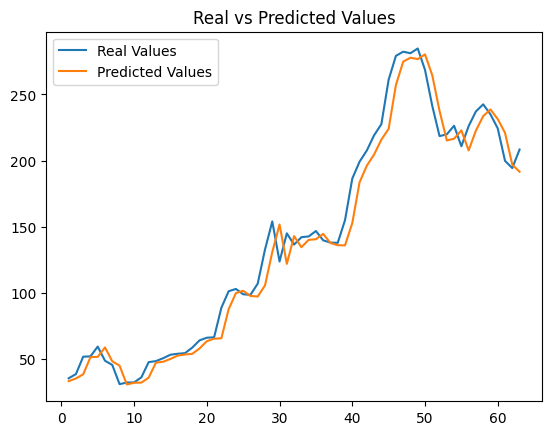

In [151]:
from sklearn.metrics import r2_score

X_test = X_test.drop(columns=['Tesla Stock Open Price','Tesla Stock Volume','Tesla Stock Adj Close Price','Tesla Stock High','Tesla Stock Low','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])
X_test=sm.add_constant(X_test)
print(X_test.head())
y_pred = lrm.predict(X_test)

# Assuming y_test and y_pred are the actual and predicted values, respectively
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

osr2=OSR2(lrm, y_train, X_test, y_test)
print("OSR2 Score:", osr2)

mean_absolute_error = np.mean(np.abs(y_test - y_pred))
mean_absolute_error_percentage = mean_absolute_error / np.mean(y_test)
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Absolute Error Percentage:", mean_absolute_error_percentage)

plt.title('Real vs Predicted Values')

plt.plot(y_test,  label= 'Real Values')
plt.plot(y_pred, label = 'Predicted Values')
plt.legend()
plt.show()

## Load Data - Train & Test split with time benchmark

#### Random split is needed for accuracy of tree-based models since the range of possible stock price values changes over time

In [152]:
# Resplit the full dataset using a random procedure
data = pd.read_csv("../data.csv")
train_data, test_data = train_test_split(data)
test_data = test_data.drop(columns=['since', 'until','Unnamed: 0'])
train_data = train_data.drop(columns=['since', 'until','Unnamed: 0'])

train_data['Previous Sentiment'] = train_data['Sentiment'].shift(1)
train_data = train_data[1:]
test_data['Previous Sentiment'] = test_data['Sentiment'].shift(1)
test_data = test_data[1:]

In [153]:
y_train = train_data['Tesla Stock Price']
X_train = train_data.drop(columns=['Tesla Stock Price','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])

y_test = test_data['Tesla Stock Price']
X_test = test_data.drop(columns=['Tesla Stock Price','S&P 500 Variance', 'Tesla Wikipedia Page Views','Nissan Stock Price','Sentiment','Ford Stock Price','GM Stock Price'])

## CART

In [154]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train, y_train)
test_pred_cart, train_pred_cart = dtr_cv.predict(X_test), dtr_cv.predict(X_train)

## RANDOM FORESTS

In [155]:
grid_values = {'max_features': np.linspace(1,5,5, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

rf2 = RandomForestRegressor() 
cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)
test_pred_rf, train_pred_rf = rf_cv.predict(X_test), rf_cv.predict(X_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.6s
[CV] END max_features=2, min_samples_leaf=5, n_es

## GRADIENT BOOSTED TREES

In [156]:
reg = GradientBoostingRegressor(random_state=99)
reg.fit(X_train, y_train)
test_pred_reg, train_pred_reg = reg.predict(X_test), reg.predict(X_train)

## Ensemble Model Blending

In [157]:
train = pd.DataFrame({'Tesla_Stock_Price': y_train, 'val_pred_cart': train_pred_cart, 'val_pred_rf': train_pred_rf, 'val_pred_reg': train_pred_reg})
test = pd.DataFrame({'Tesla_Stock_Price': y_test, 'val_pred_cart': test_pred_cart, 'val_pred_rf': test_pred_rf, 'val_pred_reg': test_pred_reg})
ensemble_model = smf.ols(formula='Tesla_Stock_Price ~ val_pred_cart+val_pred_reg+val_pred_rf -1', data=train).fit()

## Model Comparison

In [158]:
comparison_data = {'Linear Regressor': ['{:.3f}'.format(OSR2(lrm, y_train, sm.add_constant(X_test), y_test)),
                                               '{:.4f}'.format(avg_error(lrm.predict(sm.add_constant(X_test)), y_test))],
                    'Decision Tree Regressor': ['{:.3f}'.format(OSR2(dtr_cv, y_train, X_test, y_test)),
                                               '{:.4f}'.format(avg_error(dtr_cv.predict(X_test), y_test))],
                   'Random Forest': ['{:.3f}'.format(OSR2(rf_cv, y_train, X_test, y_test)),
                                     '{:.4f}'.format(avg_error(rf_cv.predict(X_test), y_test))], 
                   'Gradient Boosted Trees': ['{:.3f}'.format(OSR2(reg, y_train, X_test, y_test)),
                                              '{:.4f}'.format(avg_error(reg.predict(X_test), y_test))],
                  'Ensemble Model': ['{:.3f}'.format(OSR2(ensemble_model, y_train, test, y_test)),
                                              '{:.4f}'.format(avg_error(ensemble_model.predict(test), y_test))]}

comparison_table = pd.DataFrame(data=comparison_data, index=['OSR2', 'Average Percent Test Error'])
comparison_table

,Linear Regressor,Decision Tree Regressor,Random Forest,Gradient Boosted Trees,Ensemble Model
OSR2,0.899,0.967,0.982,0.984,0.984
Average Percent Test Error,0.2401,0.0936,0.0711,0.0732,0.0737
